In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os

In [2]:
os.chdir('/home/fgran/gaiadr3_bcg/')
import gdr3bcg.bcg as bcg
sys.path.append('/home/fgran/Downloads/gaiadr3_bcg/')
bc = bcg.BolometryTable()

In [3]:
#Move to the correct directory: Pristine-UVES
os.chdir('/store/teams/cosmos/fgran/data/Pristine-UVES/')

In [4]:
uves_p111_p112_pristine_xgboost = pd.read_csv('uves_p111_p112_pristinedr1_xgboost.csv')
# uves_p111_pristine_xgboost.rename(columns={'ra_y':'ra', 'dec_y':'dec'}, inplace=True)
# uves_p111_pristine_xgboost.drop(['ra_x', 'dec_x'], axis=1, inplace=True)

parsec_2p5 = pd.read_csv('iso/PARSEC_mh-2p5.dat', skiprows=13, delim_whitespace=True, comment='#')
parsec_2p5 = parsec_2p5[parsec_2p5.label < 4.]

In [5]:
uves_p111_p112_pristine_xgboost.head(2)

,source_id,ebv,g0,eg,bp0,ebp,rp0,erp,cahk0,ecahk,...,pmdec_error,radial_velocity,radial_velocity_error,feh_pristine_dr0,feh_pristine_dr0_sigma_up,feh_pristine_dr0_sigma_down,Vcalib,mh_xgboost,teff_xgboost,logg_xgboost
0,1166634514845213568,0.034659,11.670373,0.002767,12.097350,0.002867,11.063974,0.003820,13.051166,0.009495,...,0.015382,97.427338,0.595712,-2.87,-99.989998,-99.989998,11.990169,-2.574,4956.7,1.916
1,1172165023972931072,0.026574,12.876005,0.002772,13.314315,0.003091,12.258079,0.003841,14.291629,0.016091,...,0.016281,-67.292206,2.540182,-3.02,-99.989998,-99.989998,13.182396,-2.780,5013.6,1.923


In [6]:
#Bayler-Jones distances

In [7]:
from astroquery.vizier import Vizier
import time

In [8]:
Vizier.ROW_LIMIT = 200

In [9]:
dist_table = pd.DataFrame(columns=['rpgeo', 'b_rpgeo', 'B_rpgeo'])
dist_data = np.empty((uves_p111_p112_pristine_xgboost.ra.size, dist_table.columns.size))

In [10]:
%%time

for i, row in uves_p111_p112_pristine_xgboost.iterrows():
    dist_data[i, :] = Vizier.query_constraints(catalog='I/352/gedr3dis', Source=row.source_id, return_type='votable')[0].to_pandas()[['rpgeo', 'b_rpgeo', 'B_rpgeo']].values
    time.sleep(0.20)

CPU times: user 893 ms, sys: 9.21 ms, total: 903 ms
Wall time: 32.9 s


In [11]:
dist_table = pd.DataFrame(data=dist_data, columns=['rpgeo', 'b_rpgeo', 'B_rpgeo'])

In [12]:
uves_p111_p112_pristine_xgboost['rpgeo'] = dist_table.rpgeo.values
uves_p111_p112_pristine_xgboost['b_rpgeo'] = dist_table.b_rpgeo.values
uves_p111_p112_pristine_xgboost['B_rpgeo'] = dist_table.B_rpgeo.values

In [13]:
#Correct parallax zero point

In [14]:
# from astropy.coordinates import SkyCoord
# from astroquery.gaia import Gaia
# from astropy.table import Table
# import astropy.units as u

In [15]:
# Gaia.ROW_LIMIT = 200
# Gaia.MAIN_GAIA_TABLE = 'gaiadr3.gaia_source'

In [16]:
# zp_table = pd.DataFrame(columns=['source_id', 'rgeo', 'b_rgeo', 'B_rgeo', 'rpgeo', 'b_rpgeo', 'B_rpgeo'])
# zp_data = np.zeros((uves_p111_p112_pristine_xgboost.ra.size, zp_table.columns.size))

In [17]:
# %%time

# for i, row in uves_p111_p112_pristine_xgboost.iterrows():
#     coo = SkyCoord(ra=row.ra * u.deg, dec=row.dec * u.deg)
#     zp_data[i, :] = Gaia.query_object_async(coordinate=coo, radius=0.5*u.arcsec, columns=['source_id', 'phot_g_mean_mag', 'nu_eff_used_in_astrometry', 
#                                                                                         'pseudocolour', 'ecl_lat', 'astrometric_params_solved']).to_pandas().values

In [18]:
# zp_table = pd.DataFrame(data = zp_data, columns=['source_id', 'phot_g_mean_mag', 'nu_eff_used_in_astrometry', 'pseudocolour', 'ecl_lat', 'astrometric_params_solved', 'dist'])

In [19]:
#Correct parallax zero-point

In [20]:
# zpt.load_tables()

In [21]:
# parallax_zpt = zpt.get_zpt(zp_table.phot_g_mean_mag.values, zp_table.nu_eff_used_in_astrometry.values, zp_table.pseudocolour.values, zp_table.ecl_lat.values, zp_table.astrometric_params_solved.values)

In [22]:
# uves_p111_pristine_xgboost['parallax_zpt'] = parallax_zpt

In [23]:
#Derive loggs

In [24]:
def logg_from_BC(T_eff_star, logg_star, monh_star, MG_star, alpha_star = 0.4, Mass_ratio = 0.8):
    T_eff_sun = 5770.
    logg_sun = 4.44
    M_bol_sun = 4.74
    
    return logg_sun + 4.*np.log10(T_eff_star/T_eff_sun) + 0.4*(MG_star + BC_G(T_eff_star, logg_star, monh_star, alpha_star) - M_bol_sun) + np.log10(Mass_ratio)

def BC_G(T_eff_star, logg_star, feh_star, alpha_star):
    
    star = [T_eff_star, logg_star, feh_star, alpha_star] #Teff, logg, feh, alpha
    return bc.computeBc(star)

In [25]:
mcmc_repetitions = 100
sigma_teff = 100 #K
sigma_logg = 0.2 #K
sigma_monh = 0.1 #K
mass_ratio = 0.8
sigma_mass_ratio = 0.05 

In [26]:
# logg_par = np.empty_like(uves_p111_pristine_xgboost.logg_xgboost.values)
# elogg_par = np.empty_like(uves_p111_pristine_xgboost.logg_xgboost.values)

logg_rpgeo = np.empty_like(uves_p111_p112_pristine_xgboost.logg_xgboost.values)
elogg_rpgeo = np.empty_like(uves_p111_p112_pristine_xgboost.logg_xgboost.values)

logg_samples = np.empty(mcmc_repetitions)

In [27]:
# %%time

# for star_i in np.arange(logg_par.size):
    
#     teff_mcmc = np.random.normal(loc=uves_p111_pristine_xgboost.teff_xgboost.values[star_i], scale=sigma_teff, size=mcmc_repetitions)
#     logg_mcmc = np.random.normal(loc=uves_p111_pristine_xgboost.logg_xgboost.values[star_i], scale=sigma_logg, size=mcmc_repetitions)
#     monh_mcmc = np.random.normal(loc=uves_p111_pristine_xgboost.mh_xgboost.values[star_i], scale=sigma_monh, size=mcmc_repetitions)

#     g0_mcmc = np.random.normal(loc=uves_p111_pristine_xgboost.g0.values[star_i], 
#                                scale=(2.5/np.log(10)) * (uves_p111_pristine_xgboost.phot_g_mean_flux_error.values[star_i]/uves_p111_pristine_xgboost.phot_g_mean_flux.values[star_i]), 
#                                size=mcmc_repetitions)
#     mu_mcmc = 5*np.log10(1./(np.random.normal(loc=uves_p111_pristine_xgboost.parallax.values[star_i], scale=uves_p111_pristine_xgboost.parallax_error.values[star_i], 
#                                                                                        size=mcmc_repetitions) - uves_p111_pristine_xgboost.parallax_zpt.values[star_i])*1000.) - 5.
#     MG_mcmc = g0_mcmc - mu_mcmc
    
#     mass_ratio_mcmc = np.random.normal(loc=mass_ratio, scale=sigma_mass_ratio, size=mcmc_repetitions)

#     for mcmc_i in np.arange(mcmc_repetitions):
        
#         logg_samples[mcmc_i] = logg_from_BC(T_eff_star=teff_mcmc[mcmc_i], logg_star=logg_mcmc[mcmc_i], monh_star=monh_mcmc[mcmc_i], MG_star=MG_mcmc[mcmc_i], alpha_star=0.4, Mass_ratio=mass_ratio_mcmc[mcmc_i])
    
#     logg_par[star_i] = np.percentile(logg_samples, 50)
#     elogg_par[star_i] = np.abs(np.percentile(logg_samples, 16) - np.percentile(logg_samples, 84))/2.

In [28]:
%%time

for star_i in np.arange(logg_rpgeo.size):
    
    teff_mcmc = np.random.normal(loc=uves_p111_p112_pristine_xgboost.teff_xgboost.values[star_i], scale=sigma_teff, size=mcmc_repetitions)
    logg_mcmc = np.random.normal(loc=uves_p111_p112_pristine_xgboost.logg_xgboost.values[star_i], scale=sigma_logg, size=mcmc_repetitions)
    monh_mcmc = np.random.normal(loc=uves_p111_p112_pristine_xgboost.mh_xgboost.values[star_i], scale=sigma_monh, size=mcmc_repetitions)

    g0_mcmc = np.random.normal(loc=uves_p111_p112_pristine_xgboost.g0.values[star_i], scale=uves_p111_p112_pristine_xgboost.eg.values[star_i], size=mcmc_repetitions)
    mu_mcmc = 5*np.log10(np.random.normal(loc=uves_p111_p112_pristine_xgboost.rpgeo.values[star_i], 
                                          scale=(uves_p111_p112_pristine_xgboost.B_rpgeo.values[star_i] - uves_p111_p112_pristine_xgboost.b_rpgeo.values[star_i])/2., 
                                          size=mcmc_repetitions)) - 5.
    MG_mcmc = g0_mcmc - mu_mcmc
    
    mass_ratio_mcmc = np.random.normal(loc=mass_ratio, scale=sigma_mass_ratio, size=mcmc_repetitions)

    for mcmc_i in np.arange(mcmc_repetitions):
        
        logg_samples[mcmc_i] = logg_from_BC(T_eff_star=teff_mcmc[mcmc_i], logg_star=logg_mcmc[mcmc_i], monh_star=monh_mcmc[mcmc_i], MG_star=MG_mcmc[mcmc_i], alpha_star=0.4, Mass_ratio=mass_ratio_mcmc[mcmc_i])
    
    logg_rpgeo[star_i] = np.percentile(logg_samples, 50)
    elogg_rpgeo[star_i] = np.abs(np.percentile(logg_samples, 16) - np.percentile(logg_samples, 84))/2.

CPU times: user 8min 43s, sys: 8.76 ms, total: 8min 43s
Wall time: 8min 44s


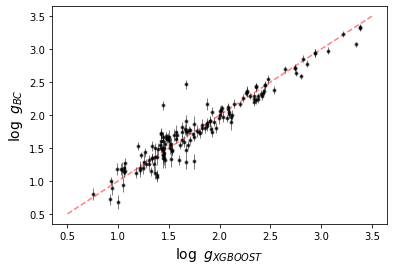

In [29]:
plt.scatter(uves_p111_p112_pristine_xgboost.logg_xgboost.values, logg_rpgeo, s=1, color='k')
plt.errorbar(uves_p111_p112_pristine_xgboost.logg_xgboost.values, logg_rpgeo, xerr=0.0, yerr=elogg_rpgeo, fmt='k.', alpha=0.5, lw=1)

x = np.linspace(0.5, 3.5)
plt.plot(x, x, color='r', alpha=0.5, ls='--')

plt.xlabel(r'$\log\ g_{XGBOOST}$', size=14)
plt.ylabel(r'$\log\ g_{BC}$', size=14)
plt.show()

In [30]:
uves_p111_p112_pristine_xgboost['logg_bc'] = logg_rpgeo
uves_p111_p112_pristine_xgboost['elogg_bc'] = elogg_rpgeo

# uves_p111_pristine_xgboost['logg_par'] = logg_par
# uves_p111_pristine_xgboost['elogg_par'] = elogg_par

In [31]:
#Plottig new loggs

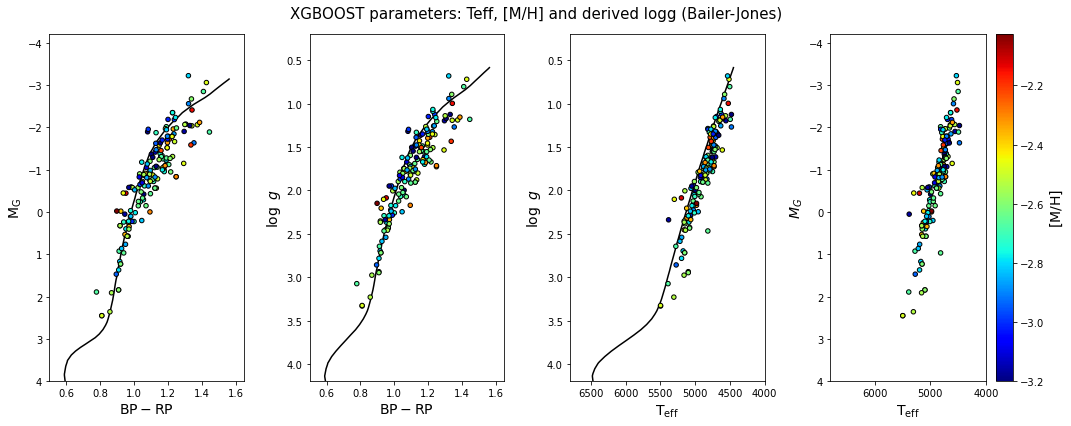

In [32]:
plt.figure(figsize=(15,6))

cmap = plt.cm.jet

plt.subplot(1,4,1)
plt.scatter(uves_p111_p112_pristine_xgboost.bp0.values - uves_p111_p112_pristine_xgboost.rp0.values, 
            uves_p111_p112_pristine_xgboost.g0.values - 5*np.log10(uves_p111_p112_pristine_xgboost.rpgeo.values) + 5., 
            s=20, c=uves_p111_p112_pristine_xgboost.mh_xgboost.values, cmap=cmap, edgecolors='k', vmin=-3.2)
plt.plot(parsec_2p5.G_BPmag.values - parsec_2p5.G_RPmag.values, parsec_2p5.Gmag.values, color='k', zorder=0)
# plt.gca().invert_yaxis()
plt.ylim(4, -4.2)
plt.xlim(0.5, 1.65)
plt.xlabel(r'${\rm BP-RP}$', size=14)
plt.ylabel(r'M$_{\rm G}$', size=14)

plt.subplot(1,4,2)
plt.scatter(uves_p111_p112_pristine_xgboost.bp0.values - uves_p111_p112_pristine_xgboost.rp0.values, uves_p111_p112_pristine_xgboost.logg_bc.values, 
            s=20, c=uves_p111_p112_pristine_xgboost.mh_xgboost.values, cmap=cmap, edgecolors='k', vmin=-3.2)
plt.plot(parsec_2p5.G_BPmag.values - parsec_2p5.G_RPmag.values, parsec_2p5.logg.values, color='k', zorder=0)
# plt.scatter(uves.bp0.values - uves.rp0.values, uves.logg_xgboost.values, s=10, color='k')
# plt.gca().invert_yaxis()
plt.ylim(4.2, 0.2)
plt.xlim(0.5, 1.65)
plt.xlabel(r'${\rm BP-RP}$', size=14)
plt.ylabel(r'$\log\ g$', size=14)


plt.subplot(1,4,3)
plt.scatter(uves_p111_p112_pristine_xgboost.teff_xgboost.values, uves_p111_p112_pristine_xgboost.logg_bc.values, 
            s=20, c=uves_p111_p112_pristine_xgboost.mh_xgboost.values, cmap=cmap, edgecolors='k', vmin=-3.2)
# plt.scatter(uves.teff_xgboost.values, uves.logg_xgboost.values, s=10, color='k')
plt.plot(10**parsec_2p5.logTe.values, parsec_2p5.logg.values, color='k', zorder=0)
# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()
plt.ylim(4.2, 0.2)
plt.xlim(6800, 4000)
plt.xlabel(r'T$_{\rm eff}$', size=14)
plt.ylabel(r'$\log\ g$', size=14)

plt.subplot(1,4,4)
plt.scatter(uves_p111_p112_pristine_xgboost.teff_xgboost.values, uves_p111_p112_pristine_xgboost.g0.values - 5*np.log10(uves_p111_p112_pristine_xgboost.rpgeo.values) + 5., 
            s=20, c=uves_p111_p112_pristine_xgboost.mh_xgboost.values, cmap=cmap, edgecolors='k', vmin=-3.2)
cb = plt.colorbar()
# plt.scatter(uves.teff_xgboost.values, uves.g0.values - 5*np.log10(1./uves.parallax.values*1000.) + 5., s=10, color='k')
# cb = plt.colorbar()
cb.set_label(label=r'${\rm [M/H]}$', fontsize=14)
# plt.plot(10**parsec_2p5.logTe.values, parsec_2p5.logg.values, color='k', zorder=0)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.ylim(4, -4.2)
plt.xlim(6800, 4000)
plt.xlabel(r'T$_{\rm eff}$', size=14)
plt.ylabel(r'$M_G$', size=14)

plt.suptitle('XGBOOST parameters: Teff, [M/H] and derived logg (Bailer-Jones)', size=15)

plt.tight_layout()
plt.show()

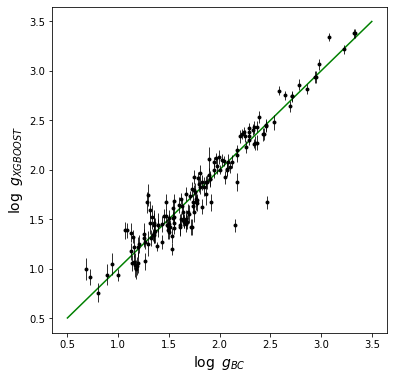

In [33]:
plt.figure(figsize=(6,6))
plt.scatter(uves_p111_p112_pristine_xgboost.logg_bc.values, uves_p111_p112_pristine_xgboost.logg_xgboost.values, s=5, color='k')
plt.errorbar(uves_p111_p112_pristine_xgboost.logg_bc.values, uves_p111_p112_pristine_xgboost.logg_xgboost.values, xerr=0.0, yerr=elogg_rpgeo, fmt='k.', alpha=0.8, lw=1)
x = np.linspace(0.5, 3.5)
plt.plot(x,x, color='g', zorder=0)

plt.xlabel(r'$\log\ g_{BC}$', size=14)
plt.ylabel(r'$\log\ g_{XGBOOST}$', size=14)
plt.show()

In [34]:
uves_p111_p112_pristine_xgboost.head(2)

,source_id,ebv,g0,eg,bp0,ebp,rp0,erp,cahk0,ecahk,...,feh_pristine_dr0_sigma_down,Vcalib,mh_xgboost,teff_xgboost,logg_xgboost,rpgeo,b_rpgeo,B_rpgeo,logg_bc,elogg_bc
0,1166634514845213568,0.034659,11.670373,0.002767,12.097350,0.002867,11.063974,0.003820,13.051166,0.009495,...,-99.989998,11.990169,-2.574,4956.7,1.916,3266.93164,3126.28369,3439.83228,1.790389,0.065886
1,1172165023972931072,0.026574,12.876005,0.002772,13.314315,0.003091,12.258079,0.003841,14.291629,0.016091,...,-99.989998,13.182396,-2.780,5013.6,1.923,4296.39062,4074.40283,4545.38330,2.049237,0.066764


In [35]:
uves_p111_p112_pristine_xgboost.to_csv('uves_p111_p112_pristinedr1_xgboost_logg.csv', index=False, header=True)